### Customize your own GPU Kernels in gQuant

The gQuant is designed to accelerate quantitive finance workflows on the GPU. The acceleration on GPU is facilitated by using cuDF dataframes organized into a computation graph. The cuDF project is a continously evolving library that provides a pandas-like API. Sometimes the data scientists are facing a few challenges that cannot be easily solved:

    1. The quantitative work needs customized logic to manipulate the data, and there are no direct methods within cuDF to support this logic.
    2. Each cuDF dataframe method call launches the GPU kernel once. For performance crtical task, it is sometimes required to wrap lots of computation steps together in a single GPU kernel to reduce the kernel launch overheads.

The solution is to build customized GPU kernels to implement them. The code and examples below illustrate a variety of approaches to implement customized GPU kernels in Python.

In [1]:
import sys; sys.path.insert(0, '..')
# Load necessary Python modules
import sys
from gquant.dataframe_flow import TaskSpecSchema, TaskGraph
from gquant.dataframe_flow import Node, NodePorts, PortsSpecSchema
import cudf
import numpy as np
from numba import cuda
import cupy
import math
import dask
import dask_cudf

Define a utility function to verify the results:

In [2]:
def verify(ground_truth, computed):
    max_difference = (ground_truth - computed).abs().max()
    # print('Max Difference: {}'.format(max_difference))
    assert(max_difference < 1e-8)
    return max_difference

### Example Problem: Calculating the distance of points to the origin

The sample problem is to take a list of points in 2-D space and compute their distance to the origin.
We start by creating a source `Node` in the graph that generates a cuDF dataframe containing some configurable number of random points. A custom node is defined by inheriting from the `Node` class and overriding methods `columns_setup` and `process`. The ports API is enabled by adding (or overriding) the `ports_setup` method. The `ports_setup` must return an instance of `NodePorts` which encapsulates the ports specs. Ports specs are dictionaries with port attributes/options per `PortsSpecSchema`.

In the case of the `PointNode` below the input port is an empty dictionary, since no inputs are required, and the output port is called "points_df_out". When using ports the `process` API must return a dictionary where the keys correspond to the output ports. The `columns_setup` is as before except that the columns dictionaries must be per port.

In [3]:
class PointNode(Node):
    def ports_setup(self):
        input_ports = {}
        output_ports = {
            'points_df_out': {
                PortsSpecSchema.port_type: cudf.DataFrame
            }
        }

        return NodePorts(inports=input_ports, outports=output_ports)

    def columns_setup(self):
        self.required = {}
        self.addition = {
           'points_df_out': {
                'x': 'float64',
                'y': 'float64'
            }
        }

    def process(self, inputs):
        npts = self.conf['npts']

        df = cudf.DataFrame()
        df['x'] = np.random.rand(npts)
        df['y'] = np.random.rand(npts)

        output = {
            'points_df_out': df,
        }

        return output

The distance can be computed via cuDF methods. We define the `DistanceNode` to calculate the euclidean distance and add a `distance_cudf` column to the output dataframe. We will use that as the ground truth to compare and verify results later. Additionally, the distance node calculates absolute distance (Manhattan distance) in another output port which is optional.


In [4]:
class DistanceNode(Node):
    def ports_setup(self):
        input_ports = {
            'points_df_in': {
                'type': cudf.DataFrame
            }
        }

        output_ports = {
            'distance_euclid_df': {
                'type': cudf.DataFrame
            },
            'distance_abs_df': {
                PortsSpecSchema.port_type: cudf.DataFrame,
                PortsSpecSchema.optional: True
            }
        }

        return NodePorts(inports=input_ports, outports=output_ports)

    def columns_setup(self):
        self.delayed_process = True

        req_cols = {
            'x': 'float64',
            'y': 'float64'
        }

        self.required = {
            'points_df_in': req_cols,            
            'distance_euclid_df': req_cols,
            'distance_abs_df': req_cols
        }

        self.addition = {
            'distance_euclid_df': {
                'distance_cudf': 'float64'
            },
            'distance_abs_df': {
                'distance_cudf': 'float64'
            }
        }

    def process(self, inputs):
        df = inputs['points_df_in']

        # DEBUGGING
        try:
            from dask.distributed import get_worker
            worker = get_worker()
            print('worker{} process NODE "{}" worker: {}'.format(
                worker.name, self.uid, worker))
            # print('worker{} NODE "{}" df type: {}'.format(
            #     worker.name, self.uid, type(df)))
        except (ValueError, ImportError):
            pass
        
        calc_absd = self.conf.get('calc_absd', False)
        if calc_absd:
            df_abs = df.copy()
            df_abs['distance_cudf'] = df['x'].abs() + df['y'].abs()

        df['distance_cudf'] = (df['x']**2 + df['y']**2).sqrt()
        

        output = {
            'distance_euclid_df': df,
        }
        
        if calc_absd:
            output['distance_abs_df'] = df_abs

        return output

Having these two nodes, we can construct a simple task graph to compute the distance.

In [5]:
# Task specifications.

points_tspec = {
    TaskSpecSchema.task_id: 'points_task',
    TaskSpecSchema.node_type: PointNode,
    TaskSpecSchema.conf: {'npts': 1000},
    TaskSpecSchema.inputs: {},
}

cudf_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_cudf',
    TaskSpecSchema.node_type: DistanceNode,
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'points_task.points_df_out'
    }
}

task_list = [points_tspec, cudf_distance_tspec]
task_graph = TaskGraph(task_list)

We can visualize the task graph with and without ports.

WITHOUT PORTS


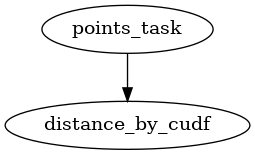

In [6]:
print('WITHOUT PORTS')
task_graph.draw(show='ipynb')

WITH PORTS


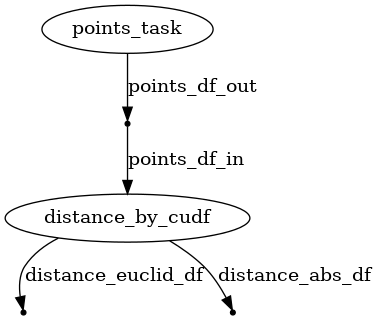

In [7]:
print('WITH PORTS')
task_graph.draw(show='ipynb', show_ports=True)

The next step is to run the task graph to obtain the distances. The output is identified by the `id` of the distance node:

In [8]:

task_list = [points_tspec, cudf_distance_tspec]
task_graph = TaskGraph(task_list)

outlist = [
    'points_task.points_df_out',
    'distance_by_cudf.distance_euclid_df',
    'distance_by_cudf.distance_abs_df'
]

try:
    (points_df, dist_euclid_df_w_cudf, dist_abs_df_w_cudf) = \
        task_graph.run(outputs=outlist)
except Exception as err:
    print(err)

ERROR: Missing output port "distance_abs_df" from node "distance_by_cudf". This output is listed in task-graph outputs.


Note the error above. We specified `distance_by_cudf.distance_abs_df` as an output, but in the `conf` of `cudf_distance_task_spec` we did not set `calc_absd` to be `True`. Therefore `distance_by_cudf.distance_abs_df` is not calculated (refer to process method of `DistanceNode` class above). Below we remove the `distance_by_cudf.distance_abs_df` from outlist and re-run.

In [9]:
outlist = ['distance_by_cudf.distance_euclid_df']
(dist_euclid_df_w_cudf,) = task_graph.run(outputs=outlist)
print('HEAD dist_euclid_df_w_cudf:\n{}'.format(dist_euclid_df_w_cudf.head()))

HEAD dist_euclid_df_w_cudf:
          x         y  distance_cudf
0  0.465057  0.356725       0.586115
1  0.818460  0.585803       1.006500
2  0.382603  0.697463       0.795512
3  0.484173  0.020433       0.484604
4  0.396552  0.721587       0.823372


Why did the above run without errors even though the `DistanceNode` defines an output port `distance_abs_df`? That's because in the `ports_setup` that port is configured to be optional.
```
'distance_abs_df': {
    'type': cudf.DataFrame,
    'optional': True
}
```

Note that instead of keywords `type` and `optional` we used `PortsSpecSchema` for these fields (to adhere to good programming practices). If we were to set `output_ports` in the `DistanceNode` as below:
```
output_ports = {
    'distance_euclid_df': {
        'type': cudf.DataFrame
    },
    'distance_abs_df': {
        'type': cudf.DataFrame
    }
```
Then the `distance_abs_df` would be non-optional and above would have produced an error as well. Try it out yourself by editing the `DistanceNode` and re-running the task-graph (remember to re-instantiate the `cudf_distance_task_spec`).

Below we set the `conf` to calculate absolute distance.

In [10]:
replace_spec = {
    'distance_by_cudf': {
        TaskSpecSchema.conf: {
            'calc_absd': True
        }
    }
}

outlist = [
    'points_task.points_df_out',
    'distance_by_cudf.distance_euclid_df',
    'distance_by_cudf.distance_abs_df'
]
(points_df, dist_euclid_df_w_cudf, dist_abs_df_w_cudf) = \
    task_graph.run(outputs=outlist, replace=replace_spec)

We could have setup the `cudf_distance_tspec` to calculate absolute distance to begin with and obtained all the outputs without errors. The above was meant to demonstrate how to work with ports.

In [11]:
print('points_df:\n{}\n'.format(points_df.head()))
print('dist_euclid_df_w_cudf:\n{}\n'.format(dist_euclid_df_w_cudf.head()))
print('dist_abs_df_w_cudf:\n{}\n'.format(dist_abs_df_w_cudf.head()))

points_df:
          x         y
0  0.499187  0.413253
1  0.786915  0.649235
2  0.322793  0.224427
3  0.060329  0.142755
4  0.668708  0.616522

dist_euclid_df_w_cudf:
          x         y  distance_cudf
0  0.499187  0.413253       0.648047
1  0.786915  0.649235       1.020167
2  0.322793  0.224427       0.393145
3  0.060329  0.142755       0.154979
4  0.668708  0.616522       0.909544

dist_abs_df_w_cudf:
          x         y  distance_cudf
0  0.499187  0.413253       0.912440
1  0.786915  0.649235       1.436150
2  0.322793  0.224427       0.547220
3  0.060329  0.142755       0.203084
4  0.668708  0.616522       1.285230



### Customized Kernel with Numba library

Numba is an excellent python library used for accelerating numerical computations. Numba supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions. The Numba GPU kernel is written in Python and translated (JIT just-in-time compiled) into GPU code at runtime. This is achieved by decorating a Python function with `@cuda.jit`. 

Just like a C/C++ CUDA GPU kernel, the `distance_kernel` function is called by thousands of threads in the GPU. The thread id is computed by `threadIdx.x`, `blockId.x` and `blockDim.x` built-in variables. Please check the [CUDA programming guild](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#thread-hierarchy) for details.

A cuDF series can be converted to GPU arrays compatible with the Numba library via.to_gpu_array` API. The next step is to define a Node that calls this Numba kernel to compute the distance and save the result into `distance_numba` column in the output dataframe.

In [13]:
@cuda.jit
def distance_kernel(x, y, distance, array_len):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if ii < array_len:
        distance[ii] = math.sqrt(x[ii]**2 + y[ii]**2)


class NumbaDistanceNode(Node):

    def ports_setup(self):
        input_ports = {
            'points_df_in': {
                PortsSpecSchema.port_type: cudf.DataFrame
            }
        }

        output_ports = {
            'distance_df': {
                PortsSpecSchema.port_type: cudf.DataFrame
            }
        }        

        return NodePorts(inports=input_ports, outports=output_ports)
    
    def columns_setup(self,):
        self.delayed_process = True

        required = {'x': 'float64',
                    'y': 'float64'}
        self.required = {
            'points_df_in': required,
            'distance_df': required
        }
        self.addition = {
            'distance_df': {'distance_numba': 'float64'}
        }

    def process(self, inputs):
        df = inputs['points_df_in']

        # DEBUGGING
        try:
            from dask.distributed import get_worker
            worker = get_worker()
            print('worker{} process NODE "{}" worker: {}'.format(
                worker.name, self.uid, worker))
            # print('worker{} NODE "{}" df type: {}'.format(
            #     worker.name, self.uid, type(df)))
        except (ValueError, ImportError):
            pass

        number_of_threads = 16
        number_of_blocks = ((len(df) - 1)//number_of_threads) + 1
        # Inits device array by setting 0 for each index.
        # df['distance_numba'] = 0.0
        darr = cuda.device_array(len(df))
        distance_kernel[(number_of_blocks,), (number_of_threads,)](
            df['x'].to_gpu_array(),
            df['y'].to_gpu_array(),
            darr,
            len(df))
        df['distance_numba'] = darr
        return {'distance_df': df}

The `self.delayed_process = True` flag in the `columns_setup` is necesary to enable the logic in the `Node` class for handling `dask_cudf` dataframes in order to use Dask (for distributed computation i.e. multi-gpu in examples later on). The `dask_cudf` dataframe does not support GPU customized kernels directly. The `to_delayed` and `from_delayed` low level interfaces of `dask_cudf` enable this support. The gQuant framework handles `dask_cudf` dataframes automatically under the hood when we set this flag.

### Customized Kernel by CuPy library

CuPy is an alternative to Numba. Numba JIT compiles Python code into GPU device code at runtime. There are some limitations in how Numba can be used as well as JIT compilation latency overhead. When a Python process calls a Numba GPU kernel for the first time Numba has to compile the Python code, and each time a new Python process is started the GPU kernel has to be recompiled. If advanced features of CUDA are needed and latency is important, CuPy is an alternative library that can be used to compile C/C++ CUDA code. CuPy caches the GPU device code on disk (default location `$(HOME)/.cupy/kernel_cache` which can be changed via `CUPY_CACHE_DIR` environment variable) thus eliminating compilation latency for subsequent Python processes.

`CuPy` GPU kernel is esentially a C/C++ GPU kernel. Below we define the `compute_distance` kernel using `CuPy`:

Using gQuant we can now define a Node that calls this CuPy kernel to compute the distance and save the results into `distance_cupy` column of a `cudf` dataframe.

In [14]:
raw_kernel = cupy.RawKernel(r'''
    extern "C" __global__
    void compute_distance(const double* x, const double* y,
            double* distance, int arr_len) {
        int tid = blockDim.x * blockIdx.x + threadIdx.x;
        if (tid < arr_len){
        distance[tid] = sqrt(x[tid]*x[tid] + y[tid]*y[tid]);
        }
    }
''', 'compute_distance')


class CupyDistanceNode(Node):

    def ports_setup(self):
        input_ports = {
            'points_df_in': {
                PortsSpecSchema.port_type: cudf.DataFrame
            }
        }

        output_ports = {
            'distance_df': {
                PortsSpecSchema.port_type: cudf.DataFrame
            }
        }

        return NodePorts(inports=input_ports, outports=output_ports)

    def columns_setup(self,):
        cols_required = {'x': 'float64',
                         'y': 'float64'}
        self.required = {
            'points_df_in': cols_required,
            'distance_df': cols_required            
        }

        self.addition = {
            'distance_df': {
                'distance_cupy': 'float64'
            }
        }
        self.delayed_process = True

    def process(self, inputs):
        df = inputs['points_df_in']
        # cupy_x = cupy.asarray(df['x'.to_gpu_array())
        # cupy_y = cupy.asarray(df['y'.to_gpu_array())
        cupy_x = cupy.asarray(df['x'])
        cupy_y = cupy.asarray(df['y'])
        number_of_threads = 16
        number_of_blocks = (len(df) - 1)//number_of_threads + 1
        dis = cupy.ndarray(len(df), dtype=cupy.float64)
        raw_kernel((number_of_blocks,), (number_of_threads,),
                   (cupy_x, cupy_y, dis, len(df)))
        df['distance_cupy'] = dis

        return {'distance_df': df}

The `self.delayed_process = True` flag is added for the same reason as with `DistanceNumbaNode` i.e. to support `dask_cudf` data frames.

### Computing using the Nodes with customized GPU kernels

First we construct the computation graph for gQuant.

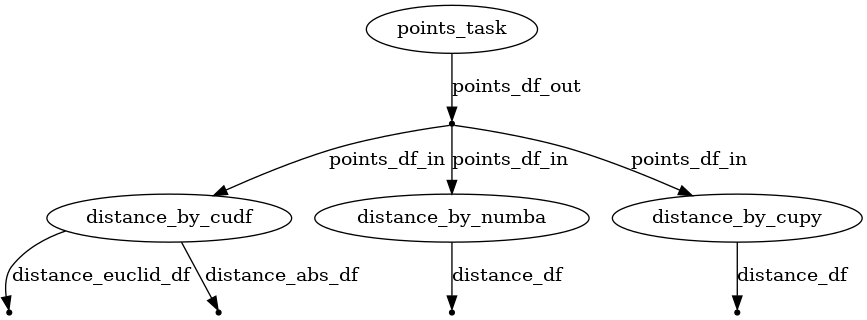

In [15]:
# For comparison to above re-use points dataframe instead
# of rand generating each time when running the task-graph.
points_tspec.update({
    TaskSpecSchema.load: {
        'points_df_out': points_df
    }
})

numba_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_numba',
    TaskSpecSchema.node_type: NumbaDistanceNode,
    TaskSpecSchema.conf: {},    
    TaskSpecSchema.inputs: {
        'points_df_in': 'points_task.points_df_out'
    },
}

cupy_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_cupy',
    TaskSpecSchema.node_type: CupyDistanceNode,
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'points_task.points_df_out'
    },
}

task_list = [
    points_tspec,
    cudf_distance_tspec,
    numba_distance_tspec,
    cupy_distance_tspec
]
task_graph = TaskGraph(task_list)

task_graph.draw(show='ipynb', show_ports=True)

Then we run the tasks.

In [16]:
out_list = [
    'distance_by_cudf.distance_euclid_df',
    'distance_by_numba.distance_df',
    'distance_by_cupy.distance_df'
]
(df_w_cudf, df_w_numba, df_w_cupy) = task_graph.run(out_list)

In [17]:
print('HEAD df_w_cudf:\n{}\n'.format(df_w_cudf.head()))
print('HEAD df_w_numba:\n{}\n'.format(df_w_numba.head()))
print('HEAD df_w_cupy:\n{}\n'.format(df_w_cupy.head()))

HEAD df_w_cudf:
          x         y  distance_cudf
0  0.499187  0.413253       0.648047
1  0.786915  0.649235       1.020167
2  0.322793  0.224427       0.393145
3  0.060329  0.142755       0.154979
4  0.668708  0.616522       0.909544

HEAD df_w_numba:
          x         y  distance_numba
0  0.499187  0.413253        0.648047
1  0.786915  0.649235        1.020167
2  0.322793  0.224427        0.393145
3  0.060329  0.142755        0.154979
4  0.668708  0.616522        0.909544

HEAD df_w_cupy:
          x         y  distance_cupy
0  0.499187  0.413253       0.648047
1  0.786915  0.649235       1.020167
2  0.322793  0.224427       0.393145
3  0.060329  0.142755       0.154979
4  0.668708  0.616522       0.909544



Use `verify` function defined above to verify the results:

In [18]:
mdiff = verify(df_w_cudf['distance_cudf'], df_w_numba['distance_numba'])
print('Max Difference cudf to numba: {}'.format(mdiff))
mdiff = verify(df_w_cudf['distance_cudf'], df_w_cupy['distance_cupy'])
print('Max Difference cudf to cupy: {}'.format(mdiff))

Max Difference cudf to numba: 2.220446049250313e-16
Max Difference cudf to cupy: 2.220446049250313e-16


To illustrate multi-input nodes let's create a verify node.

In [25]:
class VerifyNode(Node):
    def ports_setup(self):
        input_ports = {
            'df1': {
                PortsSpecSchema.port_type: [cudf.DataFrame, dask_cudf.DataFrame]
            },
            'df2': {
                PortsSpecSchema.port_type: [cudf.DataFrame, dask_cudf.DataFrame]
            }
        }
        output_ports = {
            'max_diff': {
                PortsSpecSchema.port_type: float
            }
        }

        return NodePorts(inports=input_ports, outports=output_ports)

    def columns_setup(self):
        pass

    def process(self, inputs):
        df1 = inputs['df1']
        df2 = inputs['df2']
        col_df1 = self.conf['df1_col']
        col_df2 = self.conf['df2_col']

        df1_col = df1[col_df1]
        if isinstance(df1, dask_cudf.DataFrame):
            # df1_col = df1_col.compute()
            pass

        df2_col = df2[col_df2]
        if isinstance(df2, dask_cudf.DataFrame):
            # df2_col = df2_col.compute()
            pass

        max_difference = (df1_col - df2_col).abs().max().item()

        if isinstance(max_difference, dask.dataframe.core.Scalar):
            max_difference = float(max_difference.compute())
        
        # print('Max Difference: {}'.format(max_difference))
        # assert(max_difference < 1e-8)        

        return {'max_diff': max_difference}


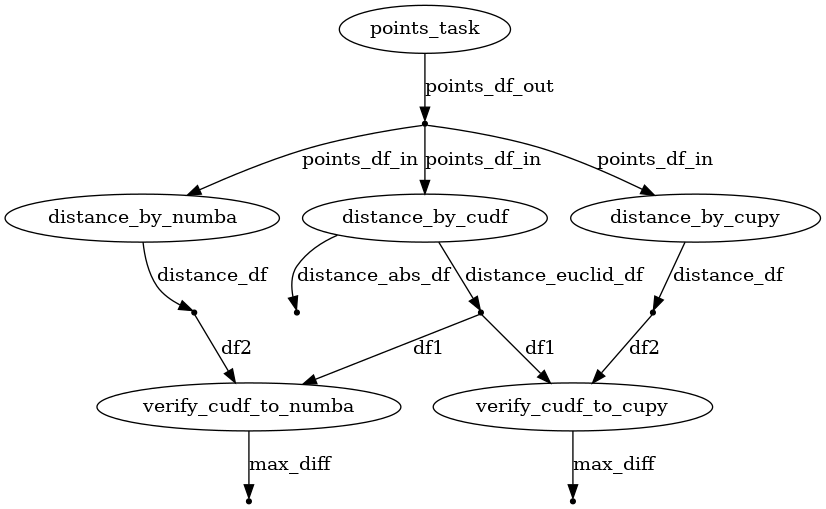

Max Difference cudf to numba: 2.220446049250313e-16
Max Difference cudf to cupy: 2.220446049250313e-16


In [26]:
verify_tspec = {
    TaskSpecSchema.task_id: 'verify_cudf_to_numba',
    TaskSpecSchema.node_type: VerifyNode,
    TaskSpecSchema.conf: {
        'df1_col': 'distance_cudf',
        'df2_col': 'distance_numba'
    },    
    TaskSpecSchema.inputs: {
        'df1': 'distance_by_cudf.distance_euclid_df',
        'df2': 'distance_by_numba.distance_df'
    }
}

verify_tspec2 = {
    TaskSpecSchema.task_id: 'verify_cudf_to_cupy',
    TaskSpecSchema.node_type: VerifyNode,
    TaskSpecSchema.conf: {
        'df1_col': 'distance_cudf',
        'df2_col': 'distance_cupy'
    },    
    TaskSpecSchema.inputs: {
        'df1': 'distance_by_cudf.distance_euclid_df',
        'df2': 'distance_by_cupy.distance_df'
    }
}

task_graph.extend([verify_tspec, verify_tspec2], replace=True)
task_graph.draw(show='ipynb', show_ports=True)
(max_cudf_to_numba_diff, max_cudf_to_cupy_diff) = task_graph.run([
    'verify_cudf_to_numba.max_diff',
    'verify_cudf_to_cupy.max_diff'
])
print('Max Difference cudf to numba: {}'.format(max_cudf_to_numba_diff))
print('Max Difference cudf to cupy: {}'.format(max_cudf_to_cupy_diff))

### Dask distributed computation

Using Dask and `dask-cudf` we can run the Nodes with customized GPU kernels on distributed dataframes. Under the hood of the `Node` class the Dask delayed processing API is handled for cudf dataframes when the `self.delayed_process = True` flag is set.

We first start a distributed Dask environment. When a dask client is instantiated it registers itself as the default Dask scheduler (<http://distributed.dask.org/en/latest/client.html>). Therefore all subsequent Dask distibuted dataframe operations will run in distributed fashion.

In [27]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38415 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


The Dask status page can be displayed in a web browser at `<ip-address>:8787`. The ip-address corresponds to the machine where the dask cluster (scheduler) was launched. Most likely same ip-address as where this jupyter notebook is running. Using the Dask status page is convenient for monitoring dask distributed processing. <http://distributed.dask.org/en/latest/web.html>

The next step is to partition the `cudf` dataframe into a `dask_cudf` dataframe. Here we make the number of partitions corresponding to the number of workers:

In [28]:
class DistributedNode(Node):

    def ports_setup(self):
        input_ports = {
            'points_df_in': {
                PortsSpecSchema.port_type: cudf.DataFrame
            }
        }

        output_ports = {
            'points_ddf_out': {
                PortsSpecSchema.port_type: dask_cudf.DataFrame
            }
        }

        return NodePorts(inports=input_ports, outports=output_ports)

    def columns_setup(self,):
        required = {
            'x': 'float64',
            'y': 'float64'
        }

        self.required = {
            'points_df_in': required,
            'points_ddf_out': required
        }

    def process(self, inputs):
        npartitions = self.conf['npartitions']
        df = inputs['points_df_in']
        ddf = dask_cudf.from_cudf(df, npartitions=npartitions)
        return {'points_ddf_out': ddf}


We add this distribution node to the computation graph to convert `cudf` dataframes into `dask-cudf` dataframes. The `dask-cudf` dataframes are handled automatically in gQuant when `self.delayed_process=True` within a `Node` implementation (setup in `columns_setup`). When using nodes with ports with `self.delayed_process=True` setting, it is required that all input and output ports be of type `cudf.DataFrame`. Otherwise don't set  `self.delayed_process` and one can write custom logic to handle distributed dataframes (refer to `VerifyNode` abover for an example where `dask_cudf` dataframes are handled directly within the process method).

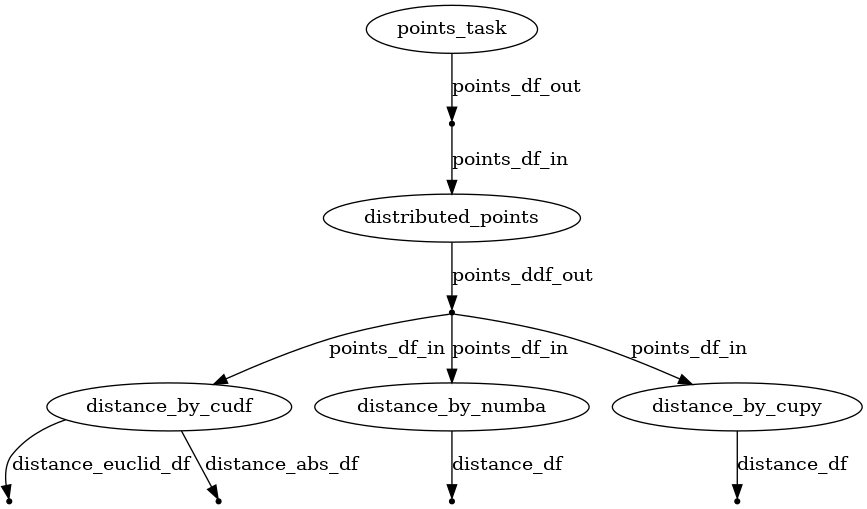

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KilledWorker: ('process-f9da4ae6-9159-4165-84e5-94df32a87748', <Worker 'tcp://127.0.0.1:45521', name: 3, memory: 0, processing: 1>)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [29]:
npartitions = len(client.scheduler_info()['workers'])


distribute_tspec = {
    TaskSpecSchema.task_id: 'distributed_points',
    TaskSpecSchema.node_type: DistributedNode,
    TaskSpecSchema.conf: {'npartitions': npartitions},
    TaskSpecSchema.inputs: {
        'points_df_in': 'points_task.points_df_out'
    }
}

dask_cudf_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_cudf',
    TaskSpecSchema.node_type: DistanceNode,
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'distributed_points.points_ddf_out'
    }
}

dask_numba_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_numba',
    TaskSpecSchema.node_type: NumbaDistanceNode,
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'distributed_points.points_ddf_out'
    }
}

dask_cupy_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_cupy',
    TaskSpecSchema.node_type: CupyDistanceNode,
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'distributed_points.points_ddf_out'
    }
}

task_list = [
    points_tspec,
    distribute_tspec,
    dask_cudf_distance_tspec,
    dask_numba_distance_tspec,
    dask_cupy_distance_tspec
]

task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb', show_ports=True)

out_list = [
    'distributed_points.points_ddf_out',
    'distance_by_cudf.distance_euclid_df',
    'distance_by_numba.distance_df',
    'distance_by_cupy.distance_df'
]
(points_ddf, ddf_w_cudf, ddf_w_numba, ddf_w_cupy) = task_graph.run(out_list)
df_w_cudf = ddf_w_cudf.compute()
df_w_numba = ddf_w_numba.compute()
df_w_cupy = ddf_w_cupy.compute()


Verify the results:

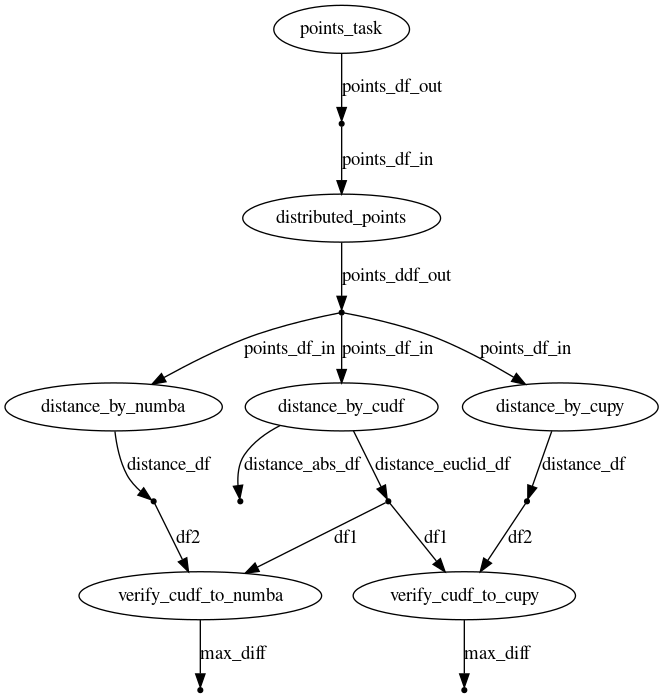

HEAD points_ddf:
          x         y
0  0.887968  0.582714
1  0.146722  0.296758
2  0.391815  0.623228
3  0.882974  0.621067
4  0.794594  0.844349

HEAD df_w_cudf:
          x         y  distance_cudf
0  0.887968  0.582714       1.062094
1  0.146722  0.296758       0.331048
2  0.391815  0.623228       0.736161
3  0.882974  0.621067       1.079522
4  0.794594  0.844349       1.159442

HEAD df_w_numba:
          x         y  distance_numba
0  0.887968  0.582714        1.062094
1  0.146722  0.296758        0.331048
2  0.391815  0.623228        0.736161
3  0.882974  0.621067        1.079522
4  0.794594  0.844349        1.159442

HEAD df_w_cupy:
          x         y  distance_cupy
0  0.887968  0.582714       1.062094
1  0.146722  0.296758       0.331048
2  0.391815  0.623228       0.736161
3  0.882974  0.621067       1.079522
4  0.794594  0.844349       1.159442

Max Difference cudf to numba: 2.220446049250313e-16
Max Difference cudf to cupy: 2.220446049250313e-16


In [23]:
verify_cudf_numba_tspec = verify_tspec.copy()
verify_cudf_cupy_tspec = verify_tspec2.copy()

task_graph.extend(
    [verify_cudf_numba_tspec,
     verify_cudf_cupy_tspec],
    replace=True)
task_graph.draw(show='ipynb', show_ports=True)

# Use results above and avoid re-running dask
replace_spec = {
    'distance_by_cudf': {
        TaskSpecSchema.load: {
            'distance_euclid_df': ddf_w_cudf
        }
    },
    'distance_by_numba': {
        TaskSpecSchema.load: {
            'distance_df': ddf_w_numba
        }
    },
    'distance_by_cupy': {
        TaskSpecSchema.load: {
            'distance_df': ddf_w_cupy
        }
    }
}

(max_cudf_to_numba_diff, max_cudf_to_cupy_diff) = task_graph.run(
    ['verify_cudf_to_numba.max_diff',
     'verify_cudf_to_cupy.max_diff'],
    replace=replace_spec
)

print('HEAD points_ddf:\n{}\n'.format(points_ddf.head()))
print('HEAD df_w_cudf:\n{}\n'.format(ddf_w_cudf.head()))
print('HEAD df_w_numba:\n{}\n'.format(ddf_w_numba.head()))
print('HEAD df_w_cupy:\n{}\n'.format(ddf_w_cupy.head()))
print('Max Difference cudf to numba: {}'.format(max_cudf_to_numba_diff))
print('Max Difference cudf to cupy: {}'.format(max_cudf_to_cupy_diff))


One limitation to be aware of when using customized kernels within Nodes in the Dask environment, is that each GPU kernel works on one partition of the dataframe. Therefore if the computation depends on other partitions of the dataframe the approach above does not work.

### Saving Custom Nodes and Kernels

The gQuant examples already implement a number of `Nodes`. These can be found in `gquant.plugin_nodes` submodules.

The customized kernels and nodes can be saved to your own python modules for future re-use instead of having to re-define them at runtime. The nodes we defined above were to a written to a python module "custom_port_nodes.py" (the `DistanceNode` was simplified to ommit the absolute distance calculation). We will re-run our workflow importing the Nodes from the custom module we wrote out.

When defining the tasks we specify `filepath` for the path to the python module that has the Node definition. Notice, that the `node_type` is specified as a string instead of class. The string is the class name of the node that will be imported for running a task.

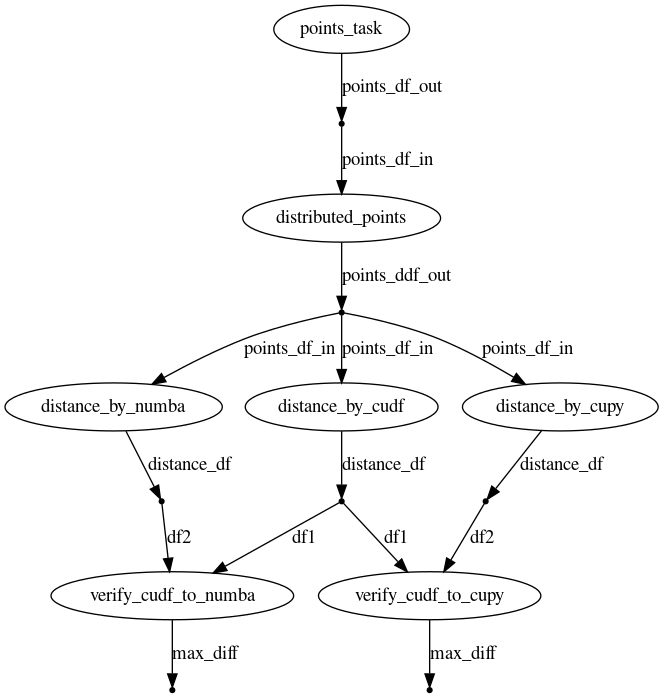

In [24]:
npartitions = len(client.scheduler_info()['workers'])

points_tspec = {
    TaskSpecSchema.task_id: 'points_task',
    TaskSpecSchema.node_type: 'PointNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {'npts': 1000},
    TaskSpecSchema.inputs: {},
}

distribute_tspec = {
    TaskSpecSchema.task_id: 'distributed_points',
    TaskSpecSchema.node_type: 'DistributedNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {'npartitions': npartitions},
    TaskSpecSchema.inputs: {
        'points_df_in': 'points_task.points_df_out'
    }
}

dask_cudf_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_cudf',
    TaskSpecSchema.node_type: 'DistanceNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'distributed_points.points_ddf_out'
    }
}

dask_numba_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_numba',
    TaskSpecSchema.node_type: 'NumbaDistanceNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'distributed_points.points_ddf_out'
    }
}

dask_cupy_distance_tspec = {
    TaskSpecSchema.task_id: 'distance_by_cupy',
    TaskSpecSchema.node_type: 'CupyDistanceNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {
        'points_df_in': 'distributed_points.points_ddf_out'
    }
}

verify_cudf_to_numba_tspec = {
    TaskSpecSchema.task_id: 'verify_cudf_to_numba',
    TaskSpecSchema.node_type: 'VerifyNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {
        'df1_col': 'distance_cudf',
        'df2_col': 'distance_numba'
    },    
    TaskSpecSchema.inputs: {
        'df1': 'distance_by_cudf.distance_df',
        'df2': 'distance_by_numba.distance_df'
    }
}

verify_cudf_to_cupy_tspec = {
    TaskSpecSchema.task_id: 'verify_cudf_to_cupy',
    TaskSpecSchema.node_type: 'VerifyNode',
    TaskSpecSchema.filepath: 'custom_port_nodes.py',
    TaskSpecSchema.conf: {
        'df1_col': 'distance_cudf',
        'df2_col': 'distance_cupy'
    },    
    TaskSpecSchema.inputs: {
        'df1': 'distance_by_cudf.distance_df',
        'df2': 'distance_by_cupy.distance_df'
    }
}

task_list = [
    points_tspec,
    distribute_tspec,
    dask_cudf_distance_tspec,
    dask_numba_distance_tspec,
    dask_cupy_distance_tspec,
    verify_cudf_to_numba_tspec,
    verify_cudf_to_cupy_tspec
]

task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb', show_ports=True)

In [25]:
out_list = [
    'distance_by_cudf.distance_df',
    'distance_by_numba.distance_df',
    'distance_by_cupy.distance_df',
    'verify_cudf_to_numba.max_diff',
    'verify_cudf_to_cupy.max_diff'
]

(ddf_w_cudf, ddf_w_numba, ddf_w_cupy,
 mdiff_cudf_to_numba, mdiff_cudf_to_cupy) = task_graph.run(out_list)

print('HEAD df_w_cudf:\n{}\n'.format(ddf_w_cudf.head()))
print('HEAD df_w_numba:\n{}\n'.format(ddf_w_numba.head()))
print('HEAD df_w_cupy:\n{}\n'.format(ddf_w_cupy.head()))
print('Max Difference cudf to numba: {}'.format(mdiff_cudf_to_numba))
print('Max Difference cudf to cupy: {}'.format(mdiff_cudf_to_cupy))


HEAD df_w_cudf:
          x         y  distance_cudf
0  0.868484  0.758179       1.152866
1  0.318385  0.046299       0.321734
2  0.844744  0.442833       0.953778
3  0.436758  0.348251       0.558602
4  0.197671  0.520553       0.556820

HEAD df_w_numba:
          x         y  distance_numba
0  0.868484  0.758179        1.152866
1  0.318385  0.046299        0.321734
2  0.844744  0.442833        0.953778
3  0.436758  0.348251        0.558602
4  0.197671  0.520553        0.556820

HEAD df_w_cupy:
          x         y  distance_cupy
0  0.868484  0.758179       1.152866
1  0.318385  0.046299       0.321734
2  0.844744  0.442833       0.953778
3  0.436758  0.348251       0.558602
4  0.197671  0.520553       0.556820

Max Difference cudf to numba: 2.220446049250313e-16
Max Difference cudf to cupy: 2.220446049250313e-16


The final illustration is how to save and load a task graph to a file for re-use.

In [26]:
task_graph.save_taskgraph('custom_wflow.yaml')
task_graph = TaskGraph.load_taskgraph('custom_wflow.yaml')

In [27]:
# update npartitions in case the scheduler is running with
# different number of workers than what was saved.
npartitions = len(client.scheduler_info()['workers'])
replace_spec = {
    'distributed_points': {
        TaskSpecSchema.conf: {'npartitions': npartitions},
    }
}

out_list = [
    'distance_by_cudf.distance_df',
    'distance_by_numba.distance_df',
    'distance_by_cupy.distance_df',
    'verify_cudf_to_numba.max_diff',
    'verify_cudf_to_cupy.max_diff'
]

(ddf_w_cudf, ddf_w_numba, ddf_w_cupy,
 mdiff_cudf_to_numba, mdiff_cudf_to_cupy) = task_graph.run(
    out_list, replace=replace_spec)

print('HEAD df_w_cudf:\n{}\n'.format(ddf_w_cudf.head()))
print('HEAD df_w_numba:\n{}\n'.format(ddf_w_numba.head()))
print('HEAD df_w_cupy:\n{}\n'.format(ddf_w_cupy.head()))
print('Max Difference cudf to numba: {}'.format(mdiff_cudf_to_numba))
print('Max Difference cudf to cupy: {}'.format(mdiff_cudf_to_cupy))

HEAD df_w_cudf:
          x         y  distance_cudf
0  0.431121  0.941755       1.035745
1  0.950709  0.448873       1.051349
2  0.224143  0.067438       0.234068
3  0.644774  0.583203       0.869401
4  0.223024  0.325308       0.394418

HEAD df_w_numba:
          x         y  distance_numba
0  0.431121  0.941755        1.035745
1  0.950709  0.448873        1.051349
2  0.224143  0.067438        0.234068
3  0.644774  0.583203        0.869401
4  0.223024  0.325308        0.394418

HEAD df_w_cupy:
          x         y  distance_cupy
0  0.431121  0.941755       1.035745
1  0.950709  0.448873       1.051349
2  0.224143  0.067438       0.234068
3  0.644774  0.583203       0.869401
4  0.223024  0.325308       0.394418

Max Difference cudf to numba: 2.220446049250313e-16
Max Difference cudf to cupy: 2.220446049250313e-16


### Conclusion

Using customized GPU kernels allows data scientists to implement and incorporate advanced algorithms. We demonstrated implementations using Numba and CuPy.

The Numba approach enables data scientists to write GPU kernels directly in the Python language. Numba is easy to use for implementing and accelerating computations. However there is some overhead incurred for compiling the kernels whenever the Numba GPU kernels are used for the first time in a Python process. Currently Numba library only supports primitive data types. Some advanced CUDA programming features, such as function pointers and function recursions are not supported. 

The Cupy method is very flexible, because data scientists are writing C/C++ GPU kernels with CUDA directly. All the CUDA programming features are supported. CuPy compiles the kernel and caches the device code to the filesystem. The launch overhead is low. Also, the GPU kernel is built statically resulting in runtime efficiency. However it might be harder for data scientists to use, because C/C++ programming is more complicated. 

Below is a brief summary comparison table:

| Methods | Development Difficulty | Flexibility | Efficiency | Latency |
|---|---|---|---|---|
| Numba method | medium | medium | low | high |
| CuPy method | hard | high  | high | low |

We recommend that the data scientists select the approach appropriate for their task taking into consideration the efficiency, latency, difficulty and flexibility of their workflow. 

In this blog, we showed how to wrap the customized GPU kernels in gQuant nodes. Also, by taking advantage of having the gQuant handle the low-level Dask interfaces for the developer, we demonstrated how to use the gQuant workflow with Dask distributed computations.

In [28]:
# Clean up

# Shutdown the Dask cluster
client.close()
cluster.close()